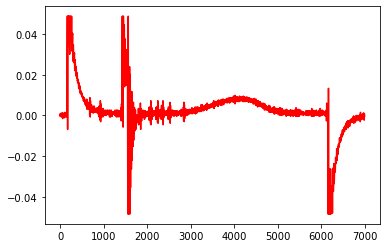

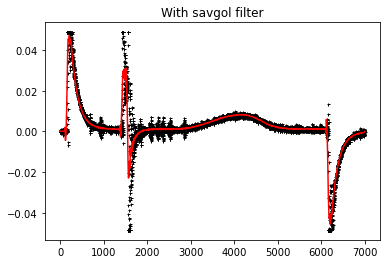

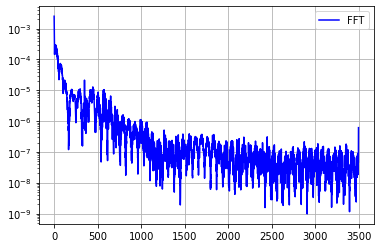

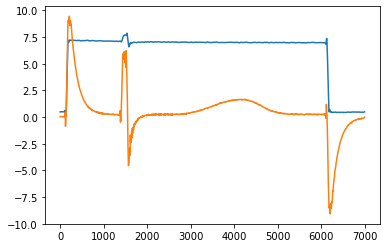

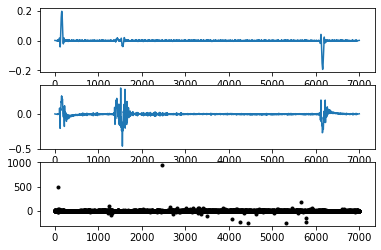

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig
import numpy as np
import scipy.optimize as opt
c1_ch1 = pd.read_csv("c4.csv")
c1_ch2 = pd.read_csv("c4_CH2.csv")

xdata = np.array(c1_ch2['X'])
ydata = np.array(c1_ch2['CH2'])
cydata = np.array(c1_ch1['CH1'])
"""
peaks = sig.find_peaks(ydata, distance=1000)
for peak in peaks[0]:
    what = peak
    plt.plot(xdata[peak], ydata[what], "k*", markersize=20)
"""
#plt.plot(c1_ch1['X'], c1_ch1['CH1'], "k.", markersize=2)
#plt.plot(c1_ch2['X'], ydata * 32.0, "b.", markersize=2)
plt.plot(xdata, ydata, "r-")
#plt.plot(c1_ch2['X'], butterFilt(diff, 10E6, fs)*3200.0, "g.")

plt.savefig("peaks/out.pdf")
plt.savefig("peaks/out.eps")
plt.figure()
plt.title("With savgol filter")
w = sig.savgol_filter(ydata, 101, 4)
plt.plot(xdata, ydata, 'k+', markersize=3)
plt.plot(xdata, w, 'r-')  # high frequency noise removed
plt.figure()
from scipy.fft import fft

N = len(w)
yf = fft(w * sig.blackman(N))

plt.semilogy(2.0/N * np.abs(yf[1:N//2]), '-b')
plt.legend(['FFT'])
plt.grid()
plt.show()
plt.figure()
tmp1 = sig.savgol_filter(cydata, 101, 4)
tmp2 = sig.savgol_filter(ydata * 200, 101, 4)
plt.plot(xdata, tmp1)
plt.plot(xdata, tmp2)
fig, ax = plt.subplots(3)

grad1 = np.gradient(tmp1)
grad2 = np.gradient(tmp2)
ax.flat[0].plot(xdata, grad1)
ax.flat[1].plot(xdata, grad2)
ax.flat[2].plot(np.log10(grad1 / grad2), "k.")

In [137]:
from scipy.optimize import curve_fit
#Just fit a basic gaussan, no recombination yet
class fitState:
    fitBegin = 0
    fitEnd = 0
    popt = []
    pcov = [[]]
    r2 = 0.0
    def __init__(self, sBegin, sEnd, sPopt, sPcov, sR2):
        self.fitBegin = sBegin
        self.fitEnd = sEnd
        self.popt = sPopt
        self.pcov = sPcov
        self.r2 = sR2
def kernel(x, a, b, c, tau):
    return a * np.exp(-(x - b)**2 / 2*c**2)*np.exp(-x / tau)
#Return a kernel for use in fitting without control of tau parameter
def tauKernel(tau):
    theLambda = lambda x, a, b, c: kernel(x, a, b, c, tau)
    return theLambda
def fitKernelToPulse(x, fitToData, peakGuess):
    guessHeight = fitToData[peakGuess]
    startFit = peakGuess
    stopFit = peakGuess
    while fitToData[startFit] > guessHeight / 8 and startFit != 0:
        startFit -= 1
    while fitToData[stopFit] > guessHeight / 8 and stopFit != len(fitToData) - 1:
        stopFit += 1
    xSubSet = x[startFit:stopFit]
    fitSubSet = fitToData[startFit:stopFit]
    # Only use a subset of data to avoid the rubbish outside the pulse
    bounds = ([guessHeight * 0.95, peakGuess*0.95, -np.inf, 0], [guessHeight * 1.05, peakGuess*1.05, np.inf, np.inf])
    p0 = [guessHeight, peakGuess, 1.99289428e-03, 5000]
    popt, pcov = curve_fit(kernel, xSubSet, fitSubSet, p0)

    fittedData = kernel(xSubSet, *popt)
    residuals = fitSubSet - fittedData
    ss_res = np.sum(residuals**2)
    ss_res = np.dot((fitSubSet - kernel(xSubSet, *popt)),(fitSubSet - kernel(xSubSet, *popt)))
    ymean = np.mean(fitSubSet)
    ss_tot = np.dot((fitSubSet-ymean),(fitSubSet-ymean))
    r2 = 1-ss_res/ss_tot

    return fitState(startFit, stopFit, popt, pcov, r2)
def assignScore(x):
    r2 = x.r2
    a, b, c, tau = x.popt
    theScore = a/c * np.log10(a)**2
    #print(f"Location = {b}, a/c = {(a/c)}, the score is {theScore}")    
    return theScore
def tryToFitKernelPulse(xdata, ydata, tre):
    fits = []
    myPeaks = sig.find_peaks(ydata, distance=1000)   
    #Speculatively fit a curve for each given peak
    for i, peak in enumerate(myPeaks[0]):     
        try:
            ret = fitKernelToPulse(xdata, ydata, peak)
            #avoid bad fits, and potentially good fits with nonsensical values of b
            print(f"{ret.r2} -- {ret.popt}")
            """
            plt.figure()
            plt.plot(xdata[peak], ydata[peak], "b*", markersize=20)
            plt.plot(xdata, ydata, "r.")
            plt.plot(xdata, kernel(xdata, *popt))
            plt.show()
            """
            if(ret.r2 > 0.1 and ret.popt[1] > 0.0): 
                print(f"Appending {tre}")      
                score = assignScore(ret)
                fits.append(ret)      
        except Exception as msg:
            #import traceback
            print(msg)
            #traceback.print_exc()
            pass
    bestFit = max(fits, key = assignScore)
    
    if(bestFit.r2 > 0.80):
        return bestFit
    assert(0, f"No fit was found for {tre}")
class Measurement:
    name = ""
    xaxis = np.array(0)
    channel1 = np.array(0)
    channel2 = np.array(0)
    increment = 0.0
    state: fitState
    fullFit = []
    #construct from a prefix i.e. "c1". I hate python
    def __init__(self, csvPrefix):
        self.name = csvPrefix
        _data = pd.read_csv(f"{csvPrefix}.csv")
        _datach2 = pd.read_csv(f"{csvPrefix}_CH2.csv")
        self.increment = _data['Increment'][0]
        assert(self.increment == _datach2['Increment'][0])
        self.xaxis = np.array(_data['X'])
        self.channel1 = np.array(_data['CH1'])
        self.channel2 = np.array(_datach2['CH2'])
        assert(np.array_equal(np.array(_datach2['X']), self.xaxis))
    # Basically just find where the peak is 
    def fitThePeak(self):
        ret = tryToFitKernelPulse(self.xaxis, self.channel2, self.name)
        self.state = ret
    def smooth(ch1, ch2):
        if ch1:
            self.channel1 = sig.savgol(self.channel1, 51, 4)
        if ch1:
            self.channel2 = sig.savgol(self.channel2, 51, 4)
    #Tau is not unique to each measurement, perform a fit with tau given above
    def fitFully(self, tauValue):
        getLambda = tauKernel(tauValue)
        timeSubset = self.channel2[self.state.fitBegin:self.state.fitEnd]
        peakSubSet = self.channel2[self.state.fitBegin:self.state.fitEnd]
        def lossFunction(x):
            #a, b, c = *x
            outputSubset = getLambda(timeSubset, x[0], x[1], x[2])
            sub = outputSubset - peakSubSet
            sumSquares = np.sum([val**2 for val in sub])
            self.fullFit = x
            return sumSquares
        x0 = self.state.popt 
        x0[-1] = tauValue
        result = opt.least_squares(lossFunction, x0)
        return result.cost
class Experiment:
    name = ""
    measurements = []
    def addByName(self, *argv):
        for i in argv:
            self.measurements.append(Measurement(i))
    def __init__(self, name):
        self.name = name
    def runFits(self):
        for i in measurements:
            i.fitThePeak()
    def deepFit(self):
        params = [p.state.popt for p in self.measurements]
        def bigLossFunction(tauValue):
            theSum = 0.0
            for idx, meas in enumerate(self.measurements):
                res = meas.fitFully(tauValue)
                theSum += res
                params[idx] = meas.fullFit
            return theSum
        result = opt.least_squares(bigLossFunction, [3000])
        plt.figure()
        fig, ax = plt.subplots(2,2, figsize=(16,9))

        for i, c in enumerate(self.measurements):
            params = c.fullFit
            print(f"Length {len(params)}")
            #params[-1] = 
            
            ax.flat[i].set_title(f"opt = {params}")
            ax.flat[i].plot(c.xaxis, c.channel2, "k-")
            ax.flat[i].plot(c.xaxis, kernel(c.xaxis, *params), "r-")
        return result.x
#Instantiated seperately just to avoid lugging around data and making copies everywhere
root = Experiment('RootExperiment')

root.addByName("c1", "c2", "c3", "c4")


iterateMeasurements = root.measurements


-3.7959636227170463 -- [-6.52614062e+00 -7.69090398e+04 -8.02709187e-04  7.57275895e+06]
0.9556994221075851 -- [1.87064845e-01 1.45969626e+03 3.15887152e-01 6.39381275e+03]
Appending c1
0.9807636651281957 -- [1.02348700e-01 3.03450992e+03 1.98091661e-03 9.22655882e+03]
Appending c1
0.9864998139114748 -- [ 7.45330201e-02  3.00595421e+03 -2.03242361e-03  2.41163669e+06]
Appending c1
0.9878480287206648 -- [ 1.07032309e-02  5.95951627e+03 -4.04292185e-01  1.09396841e+04]
Appending c1
Improper input: N=4 must not exceed M=2
-3.1830906370358374 -- [ 3.90503737e+00  6.94290380e+04 -4.43470522e-04 -6.95982087e+06]
0.9546137796976423 -- [1.12371887e-01 1.44277392e+03 3.02861048e-01 8.74720180e+03]
Appending c2
0.9685737743707423 -- [5.36774785e-02 3.40580725e+03 1.88118550e-03 5.60231037e+03]
Appending c2
0.9812423524060332 -- [ 3.43515864e-02  3.36562857e+03 -1.90477977e-03  2.19874814e+04]
Appending c2
0.043263973044316395 -- [ 4.60637723e-03  5.64338397e+03 -2.95726571e-02  5.27018385e+03]
0

<Figure size 432x288 with 0 Axes>

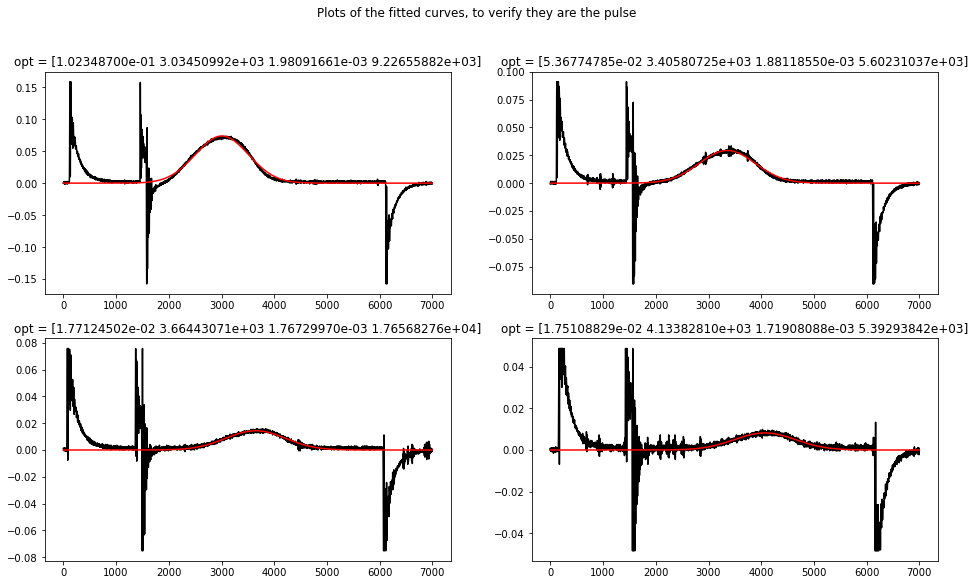

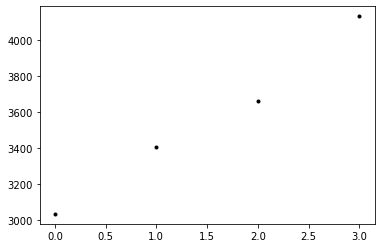

<Figure size 432x288 with 0 Axes>

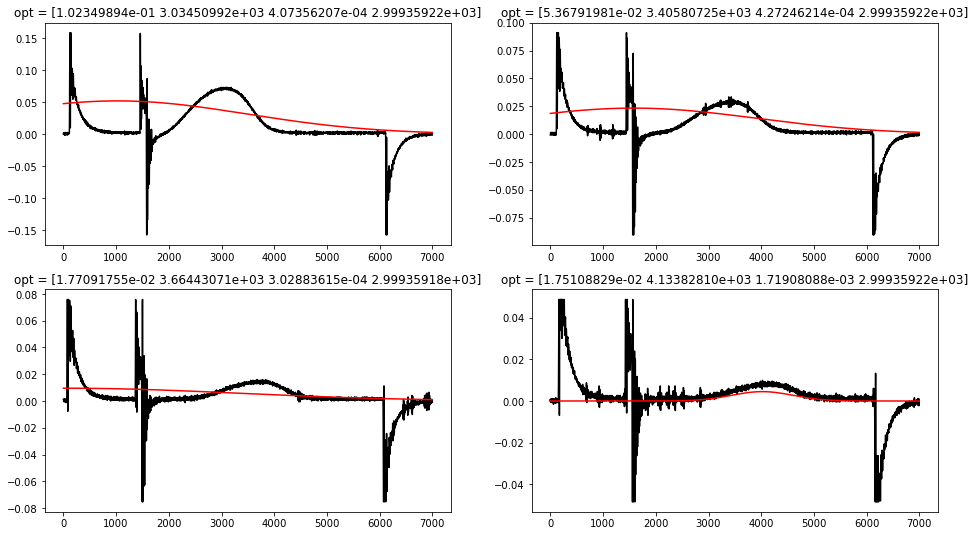

In [138]:

#plt.plot(c2_ch1_xdata, c2_ch1_ydata)

#print(ax)
output = []
for i, c in enumerate(iterateMeasurements):   
    #popt, pcov, r2 = tryToFitGaussianPulse(c.xaxis, c.channel2, c.name)
    #output.append(popt)
    c.fitThePeak()
plt.figure()
fig, ax = plt.subplots(2,2, figsize=(16,9))
fig.suptitle("Plots of the fitted curves, to verify they are the pulse")
for i, c in enumerate(iterateMeasurements):
    ax.flat[i].set_title(f"opt = {c.state.popt}")
    ax.flat[i].plot(c.xaxis, c.channel2, "k-")
    ax.flat[i].plot(c.xaxis, kernel(c.xaxis, *c.state.popt), "r-")
    
plt.savefig("quad.pdf")
plt.figure()
for i, c in enumerate(iterateMeasurements):
    plt.plot(i, c.state.popt[1], "k.")
tauValue = root.deepFit()
print(f"Resulting tau value is {tauValue}")

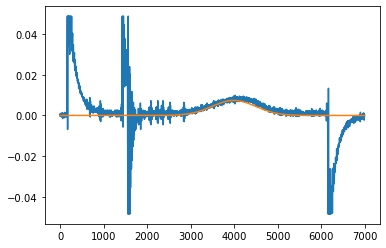

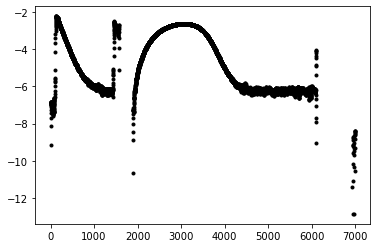

In [139]:
lin = np.linspace(0.0, 7000.0, 10000)
peakGuess = 4000
guessHeight = ydata[peakGuess]
param = [guessHeight, peakGuess, 2E-3, 50000]
plt.plot(xdata, ydata)
plt.plot(lin, kernel(lin, *param))
plt.figure()
plt.plot(iterateMeasurements[0].xaxis, np.log(sig.savgol_filter(iterateMeasurements[0].channel2, 51, 4)), "k.")

